In [5]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 200

import pandas as pd
path = '../../data/ch08/s&p500.csv'
snp500_df = pd.read_csv(path,usecols=['Adj Close'])
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change()
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1))

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 20))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [7]:
scaler = MinMaxScaler()
x_train = np.array([scaler.fit_transform(snp500_df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in range(window_length+1,len(snp500_df['log_ret']))])
x_train = x_train[:-test_samples]
x_test = x_train[-test_samples:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("테스트 데이터 비중: {}%".format((test_samples/len(x_train))*100))

테스트 데이터 비중: 4.146796599626788%


##  첫 번째 모델 : 단순 MLP 오토인코더




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4823 samples, validate on 200 samples
Epoch 1/100





4823/4823 [==============================] - 2s 460us/step - loss: 0.6960 - val_loss: 0.6951
Epoch 2/100
4823/4823 [==============================] - 0s 6us/step - loss: 0.6955 - val_loss: 0.6946
Epoch 3/100
4823/4823 [=========================

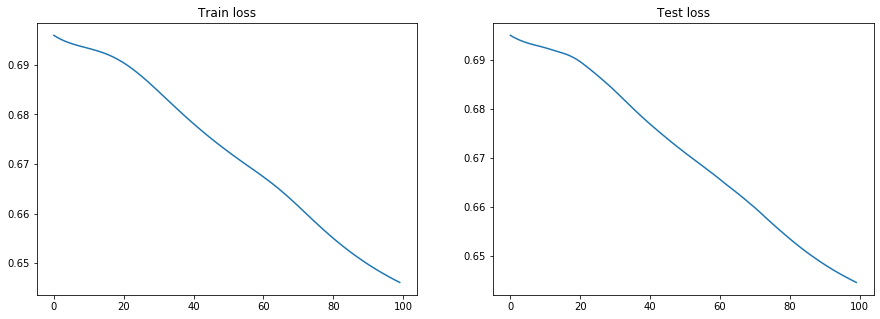

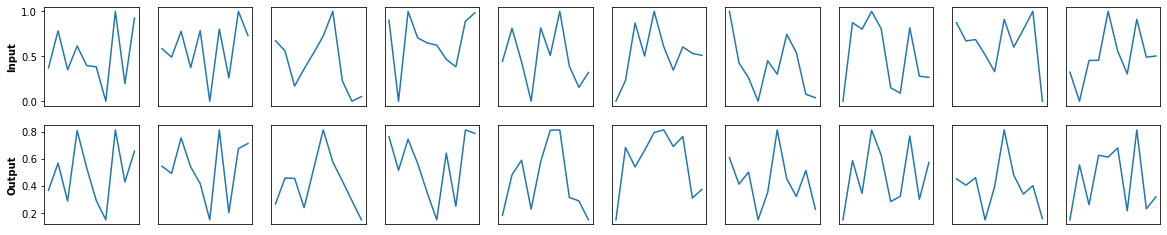

In [8]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
# "encoded"는 input데이터를 encode로 압축한다.
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded"는 압축된 데이터로 input 데이터를 최대한 표현한다.
decoded = Dense(window_length, activation='sigmoid')(encoded)

# 2개의 모델이 있다.
# 하나는 인풋데이터를 인코더 디코더를 통해 인풋값을 예측하는 모델.
autoencoder = Model(input_window, decoded)
# 다른 하나는 인풋데이터를 인코더 디코더로 압축하는 모델.
encoder = Model(input_window, encoded)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

## - 두 번째 모델 : Deep 오토인코더


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                70        
Total par

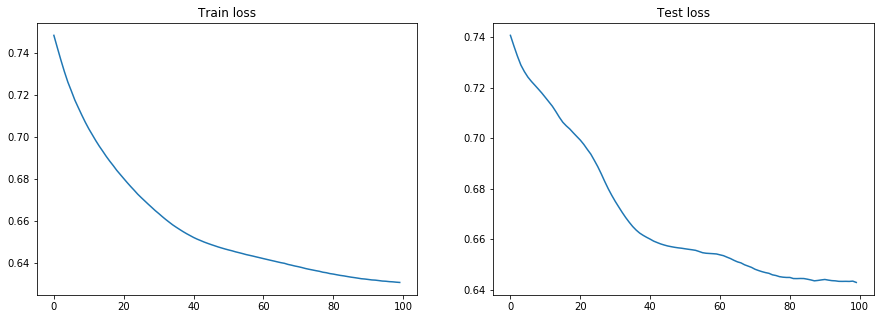

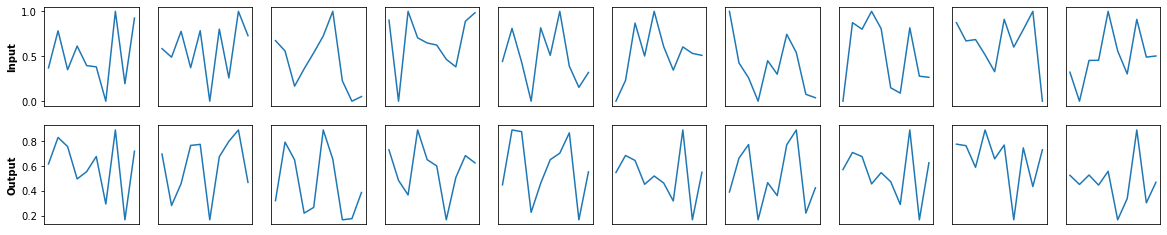

In [9]:
x_train_sample = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sample = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_sample, x_train_sample,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_sample, x_test_sample))

decoded_stocks = autoencoder.predict(x_test_sample)
plot_history(history)
plot_examples(x_test_sample, decoded_stocks)

## 1D Convolutional autoencoder


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0         
_________

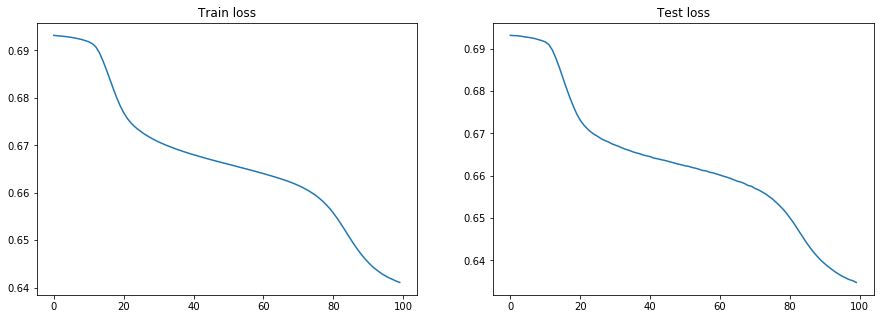

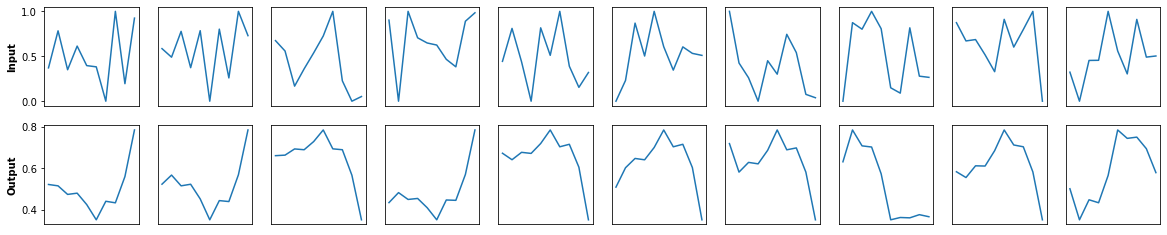

In [10]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)
plot_history(history)
plot_examples(x_test, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 3)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Train on 4823 samples, validate on 200 samples
Epoch 1/100
4823/4823 [==============================] - 2s 426us/step - loss: 8.0390 - val_loss: 8.2773
Epoch 2/100
4823/4823 [==============================] - 0s 58us/step - loss: 8.0390 - val_loss: 8.2773
Epoch 3/100
4823/4823 

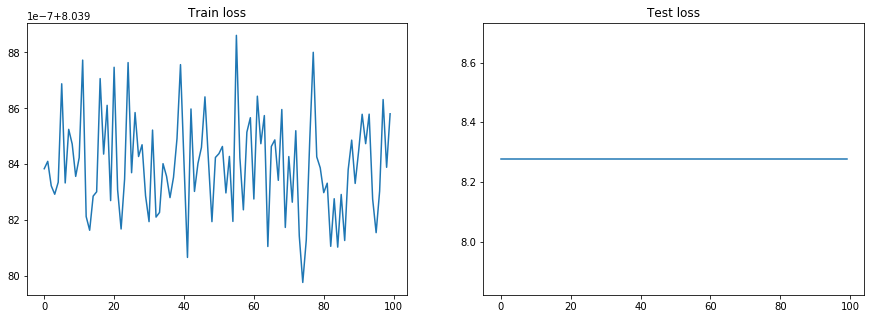

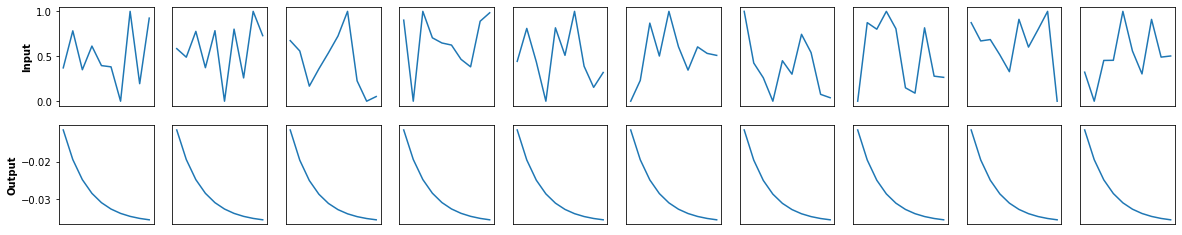

In [11]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)
plot_history(history)
plot_examples(x_test, decoded_stocks)

### Encoder를 Feature로 활용하기.

In [12]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)

autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)
#############
compress_x_train = encoder.predict(x_train_simple)
compress_x_test = encoder.predict(x_test_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 4823 samples, validate on 200 samples
Epoch 1/100
4823/4823 [==============================] - 1s 172us/step - loss: 0.7042 - val_loss: 0.7020
Epoch 2/100
4823/4823 [==============================] - 0s 6us/step - loss: 0.7027 - val_loss: 0.7005
Epoch 3/100
4823/4823 [==============================] - 0s 7us/step - loss: 0.7013 - val_loss: 0.6992
Epoch 4/100
4823/4823 [=============================

In [13]:
x_train_simple.shape

(4823, 10)

In [14]:
compress_x_train.shape

(4823, 3)

In [15]:
compress_x_test.shape

(200, 3)

#### 압축된 Feature 데이터를 입력값으로 전달한다.

In [16]:
new_feature = np.concatenate([compress_x_train,compress_x_test])
tmp_df = pd.DataFrame(new_feature,columns=['comp_fe1','comp_fe2','comp_fe3'])

In [17]:
tmp_df

,comp_fe1,comp_fe2,comp_fe3
0,1.063806,0.384725,0.472203
1,0.223034,0.649318,1.533970
2,0.746154,1.557541,0.685480
3,0.048762,1.595828,0.409649
4,0.865020,0.752582,0.369491
...,...,...,...
5018,0.195609,0.673265,1.427399
5019,0.665041,1.214911,0.000000
5020,0.990993,0.544540,0.947099
5021,1.172835,0.197761,0.324170


In [18]:
import pandas as pd
path = '../../data/ch08/s&p500.csv'
snp500_df = pd.read_csv(path,usecols=['Adj Close'])
snp500_df['pct_change'] = snp500_df['Adj Close'].pct_change()
snp500_df['log_ret'] = np.log(snp500_df['Adj Close']) - np.log(snp500_df['Adj Close'].shift(1))

In [19]:
snp500_df.loc[11:].reset_index(drop=True).join(tmp_df,how='left')

,Adj Close,pct_change,log_ret,comp_fe1,comp_fe2,comp_fe3
0,1455.140015,-0.006832,-0.006856,1.063806,0.384725,0.472203
1,1455.900024,0.000522,0.000522,0.223034,0.649318,1.533970
2,1445.569946,-0.007095,-0.007121,0.746154,1.557541,0.685480
3,1441.359985,-0.002912,-0.002917,0.048762,1.595828,0.409649
4,1401.530029,-0.027634,-0.028023,0.865020,0.752582,0.369491
...,...,...,...,...,...,...
5018,3240.020020,0.000034,0.000034,0.195609,0.673265,1.427399
5019,3221.290039,-0.005781,-0.005798,0.665041,1.214911,0.000000
5020,3230.780029,0.002946,0.002942,0.990993,0.544540,0.947099
5021,3257.850098,0.008379,0.008344,1.172835,0.197761,0.324170


In [20]:
snp500_df.shape

(5034, 3)